In [1]:
import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from optimization import (SequenceSignal, 
                          transformer_model, 
                          train_val_loops)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import pearsonr

## Train the CNN + Transformer model

In [2]:
# Global variables
DATA_DIR=Path('../ML_datasets/ATAC_data/')
X_TRAIN_PATH = DATA_DIR.joinpath('dataset_1kb_300bp_train_augmented_encoding.npy')
Y_TRAIN_PATH = DATA_DIR.joinpath('train_target_Z_scores.npy')
X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_300bp_val_encoding.npy')
Y_VAL_PATH = DATA_DIR.joinpath('val_target.npy')
N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]
N_TRAIN_EXAMPLES = np.load(Y_TRAIN_PATH).shape[0]
Z_SCORE_INVERSE_MEANS = DATA_DIR.joinpath('sample_means.npy')
Z_SCORE_INVERSE_STD = DATA_DIR.joinpath('sample_stds.npy')

BATCH_SIZE = 2048
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
                                          Y_TRAIN_PATH, 
                                          X_VAL_PATH, 
                                          Y_VAL_PATH, 
                                          BATCH_SIZE, 
                                          device = DEVICE)

In [3]:
N_EPOCHS = 30
PATIENCE = 20
OUTPUT_SHAPE = 9
CRITERION = torch.nn.MSELoss()
CHECKPOINT_NAME = DATA_DIR.joinpath('ATAC_transformer.pth')

model = transformer_model.TransformerCNNMixtureModel(n_conv_layers = 4, 
                                                     n_filters = [256, 60, 60, 120], 
                                                     kernel_sizes = [7, 3, 5, 3], 
                                                     dilation = [1, 1, 1, 1], 
                                                     drop_conv = 0.1, 
                                                     n_fc_layers = 2, 
                                                     drop_fc = 0.4, 
                                                     n_neurons = [256, 256], 
                                                     output_size = OUTPUT_SHAPE, 
                                                     drop_transformer=0.2, 
                                                     input_size=4, 
                                                     n_encoder_layers = 2, 
                                                     n_heads=8, 
                                                     n_transformer_FC_layers=256)

model.to(device=DEVICE)
summary(model)

Layer (type:depth-idx)                                            Param #
TransformerCNNMixtureModel                                        --
├─ModuleList: 1-1                                                 --
│    └─Sequential: 2-1                                            --
│    │    └─ConvPoolingBlock: 3-1                                 7,936
│    └─Sequential: 2-2                                            --
│    │    └─ConvPoolingBlock: 3-2                                 46,260
│    └─Sequential: 2-3                                            --
│    │    └─ConvPoolingBlock: 3-3                                 18,180
│    └─Sequential: 2-4                                            --
│    │    └─ConvPoolingBlock: 3-4                                 21,960
├─PositionalEncoding: 1-2                                         --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─Tr

In [4]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-3, weight_decay = 5e-3)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                             epochs = N_EPOCHS, 
                                             max_lr = 4e-3, 
                                             steps_per_epoch = math.ceil(N_TRAIN_EXAMPLES / dataloaders[0].batch_size), 
                                             pct_start = 0.1,
                                             anneal_strategy = 'linear')
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.00016
    lr: 0.00016
    max_lr: 0.004
    max_momentum: 0.95
    maximize: False
    min_lr: 1.6e-08
    weight_decay: 0.005
)


In [5]:
if not os.path.exists(CHECKPOINT_NAME):
    
    output = train_val_loops.train_N_epochs(model, optimizer, 
                                            criterion = CRITERION, 
                                            train_loader = dataloaders[0], 
                                            valid_loader = dataloaders[1], 
                                            num_epochs = N_EPOCHS, 
                                            patience = PATIENCE, 
                                            model_path = CHECKPOINT_NAME, 
                                            lr_scheduler = lr_scheduler, 
                                            means_path = Z_SCORE_INVERSE_MEANS, 
                                            stds_path = Z_SCORE_INVERSE_STD, 
                                            DEVICE = DEVICE, 
                                            use_amp=True)
else:
    
    training_state = torch.load(CHECKPOINT_NAME, 
                                weights_only = True, 
                                map_location = DEVICE)
    
    optimizer.load_state_dict(training_state['optimizer'])
    lr_scheduler.load_state_dict(training_state['lr_sched'])
    model.load_state_dict(training_state['network'])
    best_valid_loss = training_state['best_valid_loss']

Training model:
TransformerCNNMixtureModel(
  (convs): ModuleList(
    (0): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout1d(p=0.1, inplace=False)
          (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): Conv1d(256, 60, kernel_size=(3,), stride=(1,))
          (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout1d(p=0.1, inplace=False)
          (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (2): Sequential(
      (0): ConvPoolingBlock(
        (block): Sequential(
          (0): C

KeyboardInterrupt: 

In [7]:
#Load mean and std used for z-score normalization
#X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_300bp_test_encoding.npy')
#Y_VAL_PATH = DATA_DIR.joinpath('test_target.npy')
#N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]

#dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
#                                          Y_TRAIN_PATH, 
#                                          X_VAL_PATH, 
#                                          Y_VAL_PATH, 
#                                          BATCH_SIZE, 
#                                          device = DEVICE)

Y_PREDICT_PATH = DATA_DIR.joinpath('y_predict_ATAC.npy')
means = torch.from_numpy(np.load(Z_SCORE_INVERSE_MEANS)).float().to(DEVICE)
stds = torch.from_numpy(np.load(Z_SCORE_INVERSE_STD)).float().to(DEVICE)

model.eval()
y_predict = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
y_true = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():
    
    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        outputs = model(inputs)

        outputs_denorm = outputs * stds + means

        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE

        y_predict[start_idx:end_idx] = outputs_denorm
        y_true[start_idx:end_idx] = labels

y_true_array = y_true.cpu().numpy()
y_predict_array = y_predict.cpu().numpy()

print(CRITERION(y_predict, y_true))
np.save(Y_PREDICT_PATH, y_predict_array)

tensor(1.1311, device='cuda:0')


In [8]:
for j in range(OUTPUT_SHAPE):
    print(pearsonr(y_true_array[:, j], y_predict_array[:, j]))

PearsonRResult(statistic=np.float32(0.6249437), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.63078845), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6477339), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6433747), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6167054), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.66627884), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.66113347), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6572705), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float32(0.6644587), pvalue=np.float64(0.0))


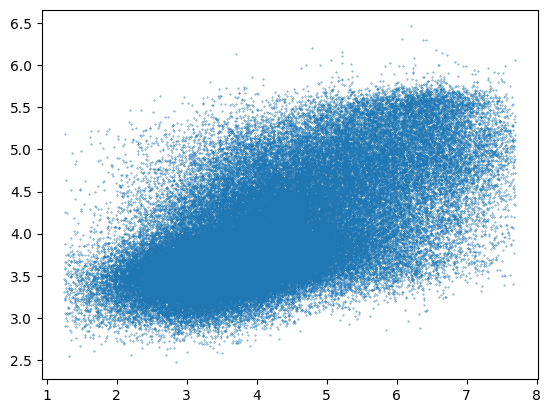

In [9]:
plt.scatter(y_true_array[:, 4], y_predict_array[:, 4], s= 0.1)

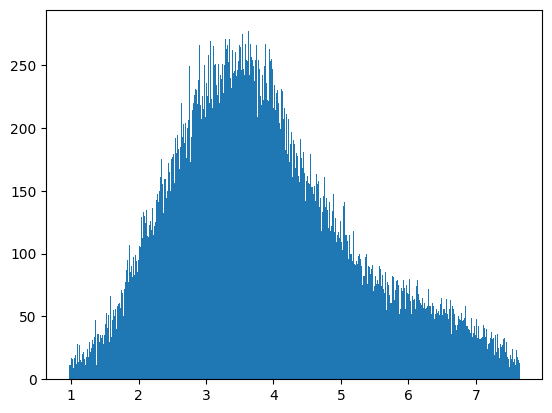

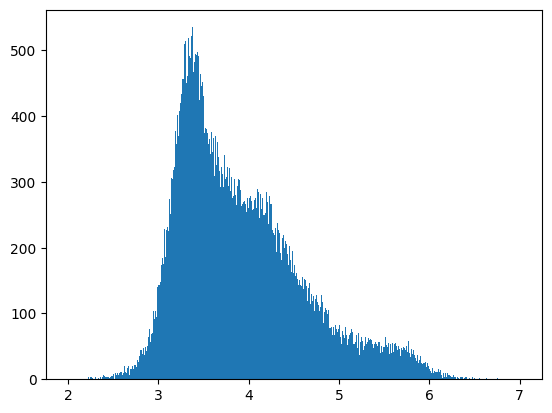

In [10]:
plt.hist(y_true_array[:, 7], bins = 1000)
plt.show()
plt.hist(y_predict_array[:, 7], bins = 1000)
plt.show()

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
import numpy as np
import pandas as pd

def make_joints_plot(C, output_dir,
                     contexts = ['E5', 'E11', 'E13', 'EAD', 'HID', 'WID', 'LB', 'AB', 'O']):
    
    sns.set_theme(style="white", font_scale = 1.5)
    x = y_true_array[:, C]
    y = y_predict_array[:, C]
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    r, _ = pearsonr(x, y)
    
    data = pd.DataFrame({'True Values': x, 'Predicted Values': y, 'Density': z})
    
    g = sns.jointplot(
        data=data, x='True Values', y='Predicted Values', 
        kind="scatter", palette="magma_r", alpha=0.7, s=10,
        marginal_kws=dict(bins=50, fill=True, color='#FF6666'), 
        height=10
    )
    
    # Joint scatter with density
    g.plot_joint(plt.scatter, c=data['Density'], cmap="magma_r", s=10, alpha=0.5)

    # Diagonal reference line
    g.ax_joint.plot([min(x), max(x)], [min(x), max(x)], 'k--', linewidth=1.5)

    # Axis labels and title
    g.ax_joint.set_xlabel("Log2 (ATAC-seq normalized signal)")
    g.ax_joint.set_ylabel("Predicted Log2 (ATAC-seq normalized signal)")
    g.ax_joint.set_title(f'{contexts[C]}', pad=70)

    # Pearson correlation annotation
    g.ax_joint.text(0.05, 0.95, f'Pearson r = {r:.2f}',
                    transform=g.ax_joint.transAxes,
                    fontsize=18, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))

    plt.savefig(output_dir.joinpath(f'jointplot_{contexts[C]}.png'), dpi=300, bbox_inches='tight')
    plt.show()

for j in range(1):
    make_joints_plot(j, DATA_DIR)

KeyboardInterrupt: 